# Competition Notebook

**Author**: Shubham Chitte  
**Date**: 2024-10-6  
**This notebook achived rank 9 in the AI competition**

---


# Section 1: Data loading and exploration

In [390]:
import os
import pandas as pd
os.chdir(r'E:\SHUBHAM\RA one drive\OneDrive - Indian School of Business\Distractor\News model\dataset')

In [392]:
df = pd.read_csv('train.csv', encoding='latin1')
df

,text,target,Word Count
0,"python courses python courses, python exercise...",academic interests,125
1,the learning point open digital education. a r...,academic interests,147
2,"tech news, latest technology, mobiles, laptops...",academic interests,143
3,the best it certification materials in usa | k...,academic interests,364
4,"bioland scientific, for your research needs bi...",academic interests,176
...,...,...,...
697522,"so while it might be hard to look at at times,...",video gaming,144
697523,"thatâ¦ You know, let's do a musical. We'll ju...",video gaming,130
697524,"PlayStation or Xbox, don't worry about being l...",video gaming,124
697525,"Elden Ring. And so, while rumors of a Sekiro 2...",video gaming,144


In [393]:
df.drop_duplicates(subset=['text'], inplace=True)

In [22]:
df.shape

(696920, 3)

In [28]:
label_counts=df['target'].value_counts()
label_counts.describe()

count       26.000000
mean     26804.615385
std       7983.984715
min      18964.000000
25%      22065.000000
50%      24326.500000
75%      29079.500000
max      58484.000000
Name: count, dtype: float64

We have major class imbalance which we will take into account before training our model

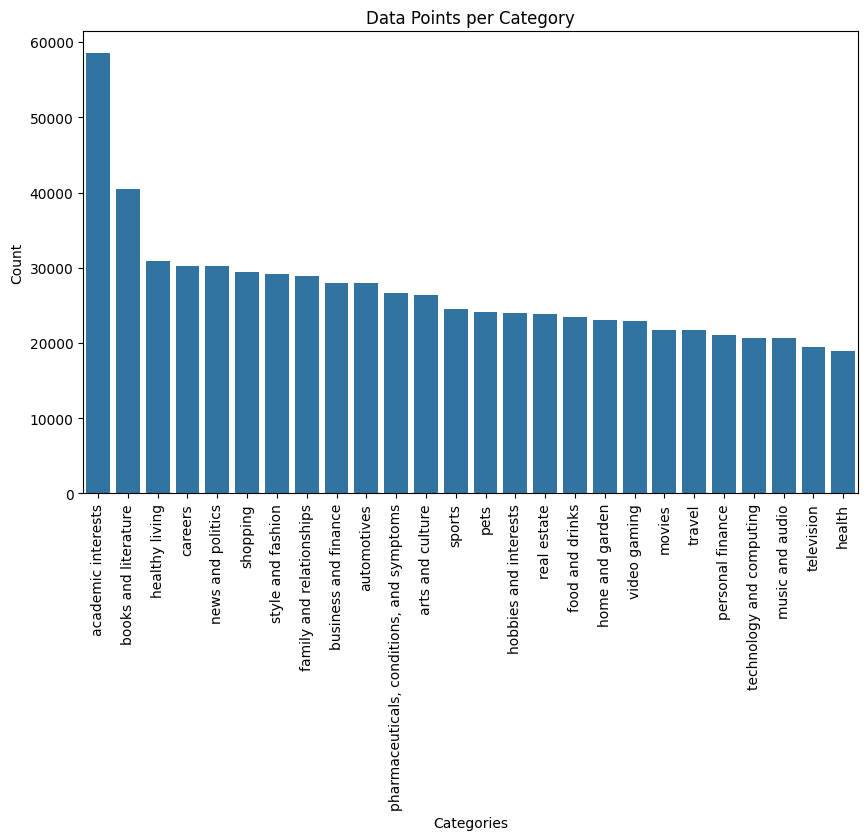

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the counts of each misconception_id
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Data Points per Category')
plt.show()

# Section 2: Text Preprocessing with NLTK

Here we have done some basic text cleaning in order for our LLM model to extract proper features.

In [396]:
!pip install contractions --target "C:\\Users\\92010\\Desktop\\CUDA STUFF\\cuda\\Lib\\site-packages"

  Obtaining dependency information for contractions from https://files.pythonhosted.org/packages/bb/e4/725241b788963b460ce0118bfd5c505dd3d1bdd020ee740f9f39044ed4a7/contractions-0.1.73-py2.py3-none-any.whl.metadata
  Using cached contractions-0.1.73-py2.py3-none-any.whl.metadata (1.2 kB)
  Obtaining dependency information for textsearch>=0.0.21 from https://files.pythonhosted.org/packages/e2/0f/6f08dd89e9d71380a369b1f5b6c97a32d62fc9cfacc1c5b8329505b9e495/textsearch-0.0.24-py2.py3-none-any.whl.metadata
  Using cached textsearch-0.0.24-py2.py3-none-any.whl.metadata (1.2 kB)
  Obtaining dependency information for anyascii from https://files.pythonhosted.org/packages/4f/7b/a9a747e0632271d855da379532b05a62c58e979813814a57fa3b3afeb3a4/anyascii-0.3.2-py3-none-any.whl.metadata
  Using cached anyascii-0.3.2-py3-none-any.whl.metadata (1.5 kB)
  Obtaining dependency information for pyahocorasick from https://files.pythonhosted.org/packages/36/76/d83c60ec7a202cbfeffaa9649d0fee6ddcb974622e411b86211f

In [400]:
import re
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    # Expand contractions like won't to will not
    text = contractions.fix(text)
    
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # Replace 3+ repeated characters with 2
    text = re.sub(r'\b[_-]+\b', '', text)  # Remove tokens consisting entirely of underscores or dashes
    text = re.sub(' +', ' ', text).strip()  # Remove extra whitespace and trim
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stopwords and apply lemmatization
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and 2 <= len(word) <= 20]
    
    return ' '.join(words)

# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)



In [418]:
df.rename(columns={'cleaned_text':'preprocessed_text'}, inplace=True)

In [420]:
df.to_csv('preprocessed_text.csv', index=False) 

# Section 3: Data arrangement prior to training

In [421]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(df['target'])

# Transform the labels
df['labels'] = le.transform(df['target'])
df.head()

,text,target,Word Count,preprocessed_text,labels
0,"python courses python courses, python exercise...",academic interests,125,python course python course python exercise py...,0
1,the learning point open digital education. a r...,academic interests,147,learning point open digital education reposito...,0
2,"tech news, latest technology, mobiles, laptops...",academic interests,143,tech news latest technology mobile laptop ndtv...,0
3,the best it certification materials in usa | k...,academic interests,364,best certification material usa killtest leadi...,0
4,"bioland scientific, for your research needs bi...",academic interests,176,bioland scientific research need bioland scien...,0


In [422]:
df_fin=df.loc[:, ['preprocessed_text', 'labels', 'target']]


I plan to compare the results of training a multilabel classification model using two strategies: equalizing the number of observations per label versus applying class-balanced weights in the cross-entropy loss function, to evaluate which method improves performance.

1st approach: I split data in train and eval datasets manually. I kept 960 observations per class in eval dataset as minmum number of observations for a class were ~ 18960. This way we keep minimum 18000 for the label with the lowest observations and avoid oversampling techniques.

In [423]:

from sklearn.model_selection import train_test_split

def split_train_eval(df, label_col='labels', eval_size=960):
    train_df_list = []
    eval_df_list = []
    
    for label, group in df.groupby(label_col):
        if len(group) <= eval_size:
            # If a label has fewer than or equal to 960 samples, send all to the eval set
            eval_df_list.append(group)
        else:
            # Otherwise, split into training and evaluation sets
            train_group, eval_group = train_test_split(group, test_size=eval_size, random_state=42, stratify=group[label_col])
            train_df_list.append(train_group)
            eval_df_list.append(eval_group)

   
    train_df = pd.concat(train_df_list)
    eval_df = pd.concat(eval_df_list)

    return train_df, eval_df

train_df, eval_df = split_train_eval(df)


In [424]:
eval_df['labels'].value_counts()

labels
0     960
1     960
24    960
23    960
22    960
21    960
20    960
19    960
18    960
17    960
16    960
15    960
14    960
13    960
12    960
11    960
10    960
9     960
8     960
7     960
6     960
5     960
4     960
3     960
2     960
25    960
Name: count, dtype: int64

In [425]:
print(eval_df.shape, train_df.shape)

(24960, 5) (671960, 5)


2nd approach: Keep equal no. of observations for each label.

In [456]:
# To avoid class imbalance, we keep equal numbers of training observations per label/target. 
# 18k was chosen because it is close to minimum observation for a label/target
import pandas as pd
from sklearn.model_selection import train_test_split


train_samples_per_label = 18000

train_data = pd.DataFrame()
eval_data = pd.DataFrame()


for label in df_fin['target'].unique():
    label_data = df_fin[df['target'] == label]  # Filter the data for this label
    
    if len(label_data) > train_samples_per_label:
        # Split into train and eval based on the 18k limit
        train_label_data, eval_label_data = train_test_split(
            label_data, 
            train_size=train_samples_per_label, 
            random_state=42
        )
    else:
        # If there are fewer than 18k, take all for training
        train_label_data = label_data
        eval_label_data = pd.DataFrame()  # Empty dataframe for evaluation
    
    # Append to train and eval datasets
    train_data = pd.concat([train_data, train_label_data])
    eval_data = pd.concat([eval_data, eval_label_data])

# Print the size of the train and eval datasets
print(f"Training data shape: {train_data.shape}")
print(f"Evaluation data shape: {eval_data.shape}")

# Check the balance of labels in both sets
print("Training label distribution:\n", train_data['target'].value_counts())
# print("Evaluation label distribution:\n", eval_data['target'].value_counts())


Training data shape: (468000, 3)
Evaluation data shape: (228920, 3)
Training label distribution:
 target
academic interests                           18000
arts and culture                             18000
travel                                       18000
television                                   18000
technology and computing                     18000
style and fashion                            18000
sports                                       18000
shopping                                     18000
real estate                                  18000
pharmaceuticals, conditions, and symptoms    18000
pets                                         18000
personal finance                             18000
news and politics                            18000
music and audio                              18000
movies                                       18000
home and garden                              18000
hobbies and interests                        18000
healthy living              

In [466]:
label_col = 'labels'

# Reducing eval_data to 960 observations per label
eval_data_reduced = eval_data.groupby(label_col, group_keys=False).apply(lambda x: x.sample(min(len(x), 960), random_state=42))

# Reset the index (optional, for cleanliness)
eval_data_reduced = eval_data_reduced.reset_index(drop=True)

# Check the number of observations per label
print(eval_data_reduced[label_col].value_counts())


labels
0     960
1     960
24    960
23    960
22    960
21    960
20    960
19    960
18    960
17    960
16    960
15    960
14    960
13    960
12    960
11    960
10    960
9     960
8     960
7     960
6     960
5     960
4     960
3     960
2     960
25    960
Name: count, dtype: int64


C:\Users\92010\AppData\Local\Temp\2\ipykernel_11644\840843308.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eval_data_reduced = eval_data.groupby(label_col, group_keys=False).apply(lambda x: x.sample(min(len(x), 960), random_state=42))


In [470]:
from datasets import Dataset, DatasetDict
raw_datasets_prep = DatasetDict({
    "train": Dataset.from_pandas(train_data.loc[:, ['preprocessed_text', 'labels']]),
    "eval": Dataset.from_pandas(eval_data_reduced.loc[:, ['preprocessed_text', 'labels']])
})
raw_datasets_prep


DatasetDict({
    train: Dataset({
        features: ['preprocessed_text', 'labels', '__index_level_0__'],
        num_rows: 468000
    })
    eval: Dataset({
        features: ['preprocessed_text', 'labels'],
        num_rows: 24960
    })
})

# Distilbert finetuninig

In [471]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

num_labels = df['target'].nunique()
model_name = 'distilbert-base-uncased'  
classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(model_name)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [472]:
print('There are', df['target'].nunique(), 'unique labels present in the data') 

There are 26 unique labels present in the data


Getting input_ids and attention_mask from text for model training

In [474]:
tokenized_datasets_prep = raw_datasets_prep.map(lambda dataset: tokenizer(dataset['preprocessed_text'], truncation=True), batched=True)
print(tokenized_datasets_prep)

Map:   0%|          | 0/468000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24960 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['preprocessed_text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 468000
    })
    eval: Dataset({
        features: ['preprocessed_text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 24960
    })
})


In [480]:
print(tokenized_datasets_prep)

DatasetDict({
    train: Dataset({
        features: ['preprocessed_text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 468000
    })
    eval: Dataset({
        features: ['preprocessed_text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 24960
    })
})


In [486]:
tokenized_datasets_prep['train']=tokenized_datasets_prep['train'].remove_columns(["preprocessed_text", "__index_level_0__"])
tokenized_datasets_prep['train']

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 468000
})

In [490]:
tokenized_datasets_prep['eval']=tokenized_datasets_prep['eval'].remove_columns("preprocessed_text")
tokenized_datasets_prep['eval']

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 24960
})

Getting classifier on cuda for parallel computing

In [492]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
classifier.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [494]:
device

device(type='cuda')

# Comparison of Distilbert with balanced weights and equal oobservations per label 

In [496]:
 # Approach with equal number of observations

from transformers import DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import evaluate


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir="distilber_equal_obs_1",
    num_train_epochs=6,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=5e-4,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model="f1",  
    greater_is_better=True,
    warmup_steps=500,
    lr_scheduler_type="linear",
    report_to="none",  
)

# Metrics computation function
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1
    }

# Initialize trainer
trainer = Trainer(
    model=classifier,
    args=training_args,
    train_dataset=tokenized_datasets_prep["train"],
    eval_dataset=tokenized_datasets_prep["eval"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] #Stop training if there is no improvement in 2 consecutive epochs.
)


# Start training
trainer.train()


C:\Users\92010\Desktop\CUDA STUFF\cuda\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.710300,0.529660,0.851362,0.851404
2,0.429200,0.516402,0.858734,0.859138
3,0.560000,0.505667,0.863902,0.864078
4,0.344000,0.557322,0.862660,0.862789
5,0.222800,0.656192,0.861378,0.861582


TrainOutput(global_step=146250, training_loss=0.41285404790079494, metrics={'train_runtime': 44250.1919, 'train_samples_per_second': 63.457, 'train_steps_per_second': 3.966, 'total_flos': 2.4537512566627987e+17, 'train_loss': 0.41285404790079494, 'epoch': 5.0})

In [500]:
# Get predictions
predictions = trainer.predict(tokenized_datasets_prep["eval"])  # Removed 'eval_dataset='
pred_labels = np.argmax(predictions.predictions, axis=1)


import numpy as np
from transformers import Trainer
from sklearn.metrics import classification_report, confusion_matrix

# Compute classification report
report_wt_dist_bal = classification_report(tokenized_datasets_prep["eval"]['labels'], pred_labels, labels=np.arange(26), zero_division=0)
print("Classification Report:")
print(report_wt_dist_bal)

# Compute confusion matrix
conf_matrix_dist_bal = confusion_matrix(tokenized_datasets_prep["eval"]['labels'], pred_labels, labels=np.arange(26))
print("Confusion Matrix:")
print(conf_matrix_dist_bal)



Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       960
           1       0.84      0.84      0.84       960
           2       0.95      0.95      0.95       960
           3       0.96      0.95      0.96       960
           4       0.83      0.78      0.80       960
           5       1.00      1.00      1.00       960
           6       0.79      0.83      0.81       960
           7       0.80      0.87      0.83       960
           8       0.80      0.78      0.79       960
           9       0.81      0.79      0.80       960
          10       0.92      0.82      0.87       960
          11       0.85      0.85      0.85       960
          12       0.84      0.86      0.85       960
          13       0.85      0.88      0.87       960
          14       0.81      0.82      0.81       960
          15       0.84      0.81      0.83       960
          16       0.93      0.88      0.90       960
    

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(15, 10))
ax = sns.heatmap(conf_matrix_dist_bal, annot=True, fmt="d", cmap="YlGnBu", cbar=True)

# Customize the axis labels
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.title('Confusion Matrix Heatmap balanced weights Distilbert')
plt.show()


 Approach with cross entropy and balanced weights


In [435]:
 
import torch
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

labels = np.array(tokenized_datasets_prep['train']['labels'])

# Compute balanced weights for each class
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Custom loss function with class weights
def custom_loss(output, target):
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(output.device))
    return loss_fct(output, target)

class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

class_weights_tensor

tensor([0.4493, 1.0182, 0.9563, 0.6550, 0.9553, 0.8821, 0.9237, 1.1505, 1.4355,
        0.8621, 1.1249, 1.1726, 1.2418, 1.3144, 0.8844, 1.2824, 1.1158, 1.0081,
        1.1303, 0.9066, 1.0965, 0.9176, 1.3085, 1.3925, 1.2472, 1.1758])

In [436]:
 # This got interupted due to sudden restart
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import evaluate


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir="distilber_balanced_wts_1",
    num_train_epochs=6,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=5e-4,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_steps=500,
    lr_scheduler_type="linear",
    report_to="none",  
)

# Metrics computation function
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1
    }

# Initialize trainer
trainer = CustomTrainer(
    model=classifier,
    args=training_args,
    train_dataset=tokenized_datasets_prep["train"],
    eval_dataset=tokenized_datasets_prep["eval"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# Start training
trainer.train()


C:\Users\92010\Desktop\CUDA STUFF\cuda\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.549900,0.544015,0.848037,0.848325
2,0.438300,0.507289,0.859335,0.859222
3,0.335600,0.518419,0.865064,0.865303
4,0.349100,0.571660,0.864824,0.865084
5,0.140800,0.664395,0.862780,0.862916


TrainOutput(global_step=209990, training_loss=0.38098081063117817, metrics={'train_runtime': 67341.2293, 'train_samples_per_second': 59.871, 'train_steps_per_second': 3.742, 'total_flos': 3.508612928222445e+17, 'train_loss': 0.38098081063117817, 'epoch': 5.0})

In [452]:
# Perform evaluation on the reduced dataset
# evaluation_results = trainer.evaluate(eval_dataset=tokenized_datasets_prep["eval"])

# Get predictions
predictions = trainer.predict(tokenized_datasets_prep["eval"])  # Removed 'eval_dataset='
pred_labels = np.argmax(predictions.predictions, axis=1)


import numpy as np
from transformers import Trainer
from sklearn.metrics import classification_report, confusion_matrix

# Compute classification report
report_wt_dist = classification_report(tokenized_datasets_prep["eval"]['labels'], pred_labels, labels=np.arange(26), zero_division=0)
print("Classification Report:")
print(report_wt_rob)

# Compute confusion matrix
conf_matrix_wt_dist = confusion_matrix(tokenized_datasets_prep["eval"]['labels'], pred_labels, labels=np.arange(26))
print("Confusion Matrix:")
print(conf_matrix_wt_dist)


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       960
           1       0.83      0.84      0.84       960
           2       0.96      0.96      0.96       960
           3       0.94      0.97      0.95       960
           4       0.82      0.84      0.83       960
           5       1.00      1.00      1.00       960
           6       0.77      0.88      0.82       960
           7       0.85      0.86      0.86       960
           8       0.84      0.80      0.82       960
           9       0.84      0.85      0.84       960
          10       0.94      0.82      0.88       960
          11       0.90      0.87      0.88       960
          12       0.85      0.84      0.85       960
          13       0.88      0.86      0.87       960
          14       0.82      0.86      0.84       960
          15       0.86      0.85      0.85       960
          16       0.90      0.88      0.89       960
    

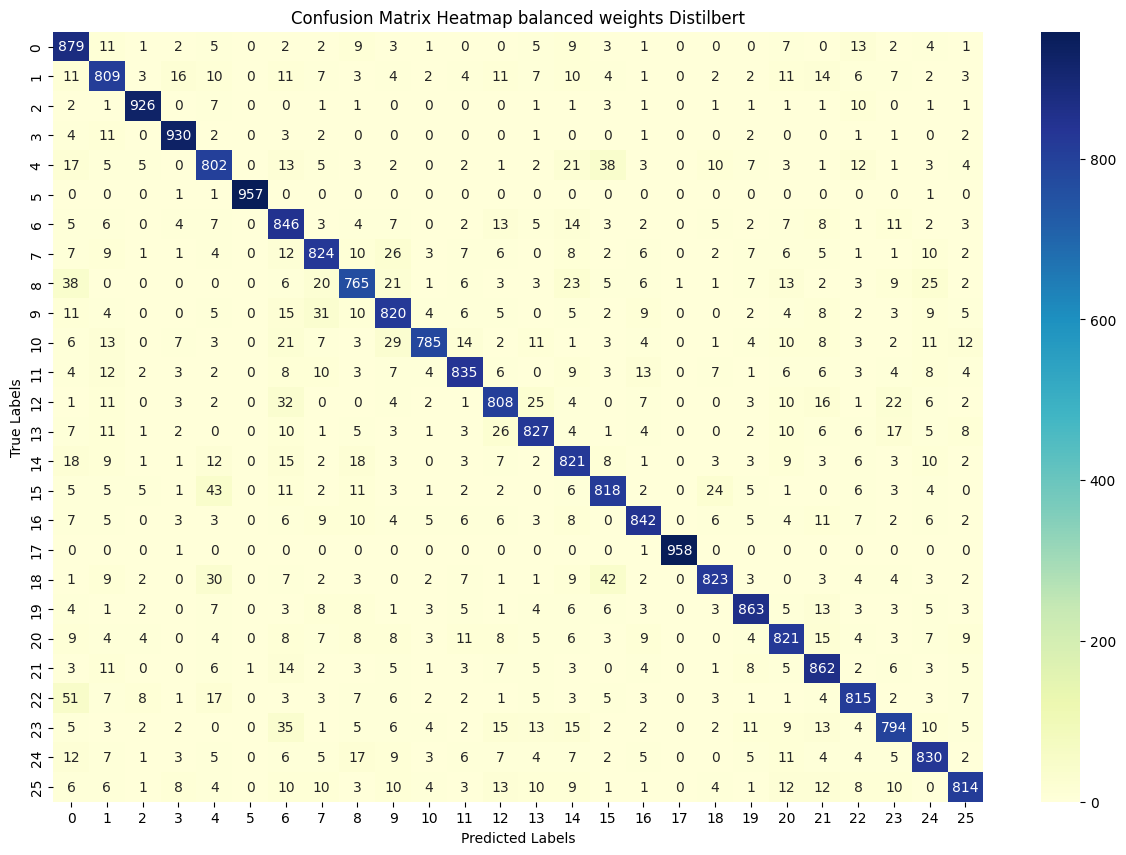

In [453]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(15, 10))
ax = sns.heatmap(conf_matrix_wt_rob, annot=True, fmt="d", cmap="YlGnBu", cbar=True)

# Customize the axis labels
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.title('Confusion Matrix Heatmap balanced weights Distilbert')
plt.show()


In [114]:
test_df = pd.read_csv('test.csv', encoding='latin1')
test_df.head()

,text,Word Count,Index
0,"equl offers enzyme assay kits, reagent mixture...",353,Article_0
1,gauthmath: instant math questions solver for f...,112,Article_1
2,Whats the No. 1 cause of blindness in older ad...,340,Article_2
3,Surfers will ride a wave in the Amazon this we...,465,Article_3
4,"Why is the top of a leaf the most colorful, so...",269,Article_4


In [116]:
preprocess_text(test_df)

,text,Word Count,Index,preprocessed_text
0,"equl offers enzyme assay kits, reagent mixture...",353,Article_0,equl offers enzyme assay kits reagent mixtures...
1,gauthmath: instant math questions solver for f...,112,Article_1,gauthmath instant math questions solver free a...
2,Whats the No. 1 cause of blindness in older ad...,340,Article_2,whats < NUM > cause blindness older adults uni...
3,Surfers will ride a wave in the Amazon this we...,465,Article_3,surfers ride wave amazon week sciencethis week...
4,"Why is the top of a leaf the most colorful, so...",269,Article_4,top leaf colorful sometimes bright red undersi...
...,...,...,...,...
174377,his story will soon pale in comparison next to...,119,Article_174377,story soon pale comparison next ciriâs oneti...
174378,Mundo.Take a look at a gallery of covers below...,115,Article_174378,mundotake look gallery covers belowimage < NUM...
174379,may change over the course of the game's devel...,141,Article_174379,may change course games development exciting s...
174380,Mark Gustafson. If you've already watched it a...,101,Article_174380,mark gustafson youve already watched arent sur...


In [124]:
# Create Dataset object from test dataframe (this is before tokenization)
test_dataset = Dataset.from_pandas(test_df[['preprocessed_text']])
# Tokenize the 'preprocessed_text' column
def tokenize_function(examples):
    return tokenizer(examples['preprocessed_text'], truncation=True, padding=True)

# Apply the tokenizer to the test dataset
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/174382 [00:00<?, ? examples/s]

In [125]:
tokenized_test_dataset

Dataset({
    features: ['preprocessed_text', 'input_ids', 'attention_mask'],
    num_rows: 174382
})

In [128]:
tokenized_test_dataset = tokenized_test_dataset.remove_columns(['preprocessed_text'])


In [347]:
# Make predictions using the Trainer
test_predictions = trainer.predict(tokenized_test_dataset)

# Get predicted labels (index of max logits)
test_pred_labels = np.argmax(test_predictions.predictions, axis=1)

# Inverse transform the encoded labels to get original labels
original_labels = le.inverse_transform(test_pred_labels)

# Add the predicted labels to the test dataframe
test_df['predicted_label'] = original_labels

# Preparing the submission DataFrame
submission_df = test_df[['predicted_label', 'Index']]

# Renaming 'predicted_label' to 'target' as required
submission_df.rename(columns={"predicted_label": "target"}, inplace=True)

# Saving the submission file with latin1 encoding
submission_df.to_csv('submission_3.csv', index=False, encoding='latin1')

# Check the first few rows to verify
submission_df.head()


C:\Users\92010\AppData\Local\Temp\2\ipykernel_11644\2716944087.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df.rename(columns={"predicted_label": "target"}, inplace=True)


,target,Index
0,hobbies and interests,Article_0
1,movies,Article_1
2,hobbies and interests,Article_2
3,hobbies and interests,Article_3
4,health,Article_4


# Appendix

I tried to use Roberta. It's results were marginally better that Distilbert. However, considering less time to train Distilbert is better. Classification report attached for roberta below.

In [ ]:
'''
Classification Report: Roberta
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       960
           1       0.83      0.84      0.84       960
           2       0.96      0.96      0.96       960
           3       0.94      0.97      0.95       960
           4       0.82      0.84      0.83       960
           5       1.00      1.00      1.00       960
           6       0.77      0.88      0.82       960
           7       0.85      0.86      0.86       960
           8       0.84      0.80      0.82       960
           9       0.84      0.85      0.84       960
          10       0.94      0.82      0.88       960
          11       0.90      0.87      0.88       960
          12       0.85      0.84      0.85       960
          13       0.88      0.86      0.87       960
          14       0.82      0.86      0.84       960
          15       0.86      0.85      0.85       960
          16       0.90      0.88      0.89       960
          17       1.00      1.00      1.00       960
          18       0.92      0.86      0.89       960
          19       0.91      0.90      0.90       960
          20       0.85      0.86      0.85       960
          21       0.85      0.90      0.87       960
          22       0.88      0.85      0.86       960
          23       0.87      0.83      0.85       960
          24       0.86      0.86      0.86       960
          25       0.90      0.85      0.88       960

    accuracy                           0.88     24960
   macro avg       0.88      0.88      0.88     24960
weighted avg       0.88      0.88      0.88     24960
'''

I tried to use some classic ML models and i got good f1 score with Adaboost model with following params. Classification report attached.

In [ ]:
# With same text preprocessing and Tf-idf vectorization
adaboost = MultiOutputClassifier(AdaBoostClassifier(
    n_estimators=50,  # Set based on repository recommendations
    learning_rate=1.04,  # Set based on repository recommendations
    algorithm='SAMME.R',  # Using SAMME.R algorithm as specified
    random_state=42  # Ensuring reproducibility
))


In [ ]:
'''
Classification Report: Adaboost (split was uneven hence some labels are missing)
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     95792
           1       0.94      0.88      0.91      5350
           2       0.92      0.97      0.95    115550
           3       0.81      0.57      0.67     18354
           4       0.84      0.74      0.79     52401
           5       0.81      0.88      0.84     80521
           6       0.94      0.98      0.96    119782
           7       0.79      0.59      0.67     26074
           8       0.80      0.59      0.68     25471
           9       0.82      0.67      0.74     46424
          10       0.88      0.94      0.91    100900
          11       0.80      0.58      0.67     12621
          12       0.80      0.83      0.81     67727
          13       0.81      0.72      0.76     50376
          14       0.88      0.94      0.91    100763
          15       0.84      0.90      0.87     86880
          16       0.78      0.56      0.65     41068
          17       0.81      0.85      0.83     74437
          18       0.90      0.96      0.93    111675
          19       0.86      0.93      0.89     95430
          20       0.80      0.62      0.70     38138
          21       0.80      0.58      0.67     29155
          22       0.72      0.49      0.59      6015
          23       0.76      0.56      0.65     27428

   micro avg       0.86      0.85      0.85   1428332
   macro avg       0.83      0.76      0.79   1428332
weighted avg       0.85      0.85      0.85   1428332
 samples avg       0.86      0.86      0.85   1428332

 '''